In [7]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import seaborn as sns


## Ventas físicas

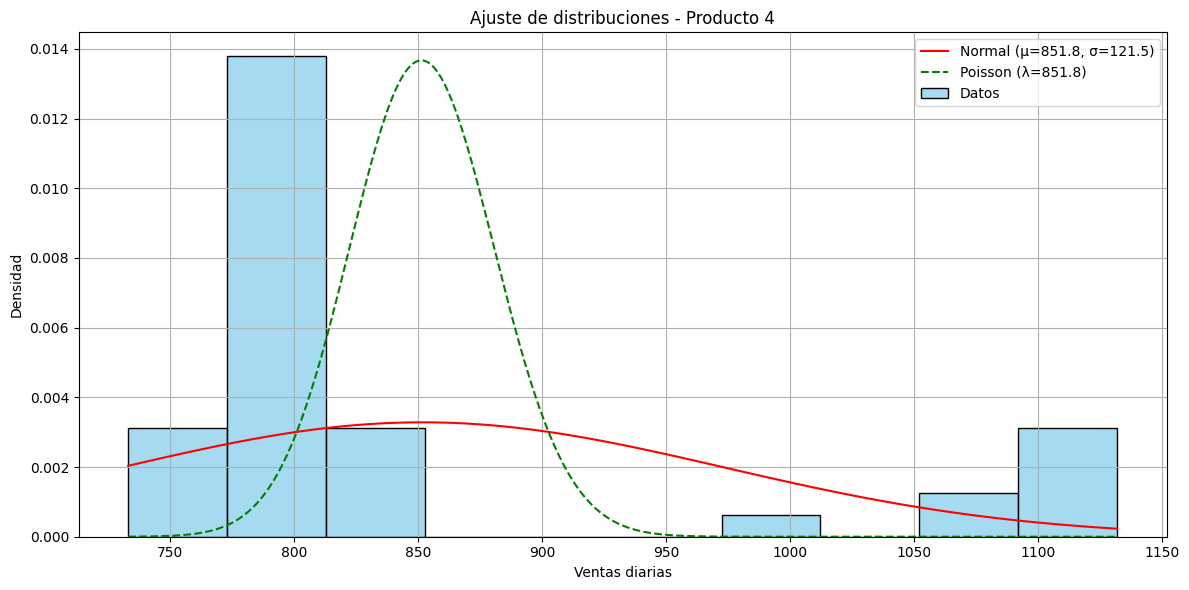

In [8]:
# === 1. Extraer archivos de un .zip ===
def extraer_ventas(zip_path, extract_dir="venta_tienda"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    all_files = [f for f in os.listdir(extract_dir) if f.endswith(".csv")]
    all_data = []
    for f in all_files:
        df = pd.read_csv(os.path.join(extract_dir, f))
        df["archivo"] = f
        df["dia"] = int(f.split("_")[2].replace(".csv", ""))
        all_data.append(df)

    df_ventas = pd.concat(all_data, ignore_index=True)
    df_ventas.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
    return df_ventas

# === 2. Agrupar por producto y día ===
def agrupar_por_producto(df_ventas):
    return df_ventas.groupby(["id_producto", "dia"])["venta_tienda"].sum().reset_index()

# === 3. Graficar distribuciones por producto ===
def graficar_ajustes(ventas_df, producto_id):
    datos = ventas_df[ventas_df["id_producto"] == producto_id]["venta_tienda"]
    mu, std = norm.fit(datos)
    lambda_p = datos.mean()

    plt.figure(figsize=(12, 6))
    sns.histplot(datos, bins=10, kde=False, stat='density', color='skyblue', label='Datos')

    x = np.linspace(datos.min(), datos.max(), 100)
    plt.plot(x, norm.pdf(x, mu, std), 'r-', label=f'Normal (μ={mu:.1f}, σ={std:.1f})')

    x_p = np.arange(datos.min(), datos.max() + 1)
    plt.plot(x_p, poisson.pmf(x_p, lambda_p), 'g--', label=f'Poisson (λ={lambda_p:.1f})')

    plt.title(f"Ajuste de distribuciones - Producto {producto_id}")
    plt.xlabel("Ventas diarias")
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === USO ===
# 1. Reemplaza 'ruta_zip' con la ruta de tu archivo .zip
ruta_zip = 'venta_tienda.zip'
ventas_raw = extraer_ventas(ruta_zip)

# 2. Agrupa y analiza
ventas_diarias = agrupar_por_producto(ventas_raw)

# 3. Graficar para un producto específico
graficar_ajustes(ventas_diarias, producto_id=4)


In [ ]:
from scipy.stats import kstest, norm, poisson, gamma, lognorm

def evaluar_distribuciones_con_lognorm(ventas_df):
    productos = ventas_df["id_producto"].unique()
    resumen_resultados = []

    for producto_id in productos:
        datos = ventas_df[ventas_df["id_producto"] == producto_id]["venta_tienda"]

        # Normal
        mu, std = norm.fit(datos)
        ks_normal = kstest(datos, 'norm', args=(mu, std))

        # Poisson
        lambda_p = datos.mean()
        ks_poisson = kstest(datos, 'poisson', args=(lambda_p,))

        # Gamma
        datos_gamma = datos[datos > 0]
        if len(datos_gamma) > 0:
            try:
                alpha_gamma, loc_gamma, scale_gamma = gamma.fit(datos_gamma, floc=0)
                ks_gamma = kstest(datos, 'gamma', args=(alpha_gamma, loc_gamma, scale_gamma))
            except Exception:
                ks_gamma = type('obj', (object,), {'pvalue': 0})()
        else:
            ks_gamma = type('obj', (object,), {'pvalue': 0})()

        # Log-Normal
        datos_lognorm = datos[datos > 0]
        if len(datos_lognorm) > 0:
            try:
                s_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(datos_lognorm, floc=0)
                ks_lognorm = kstest(datos, 'lognorm', args=(s_lognorm, loc_lognorm, scale_lognorm))
            except Exception:
                ks_lognorm = type('obj', (object,), {'pvalue': 0})()
        else:
            ks_lognorm = type('obj', (object,), {'pvalue': 0})()

        # Elegir la mejor distribución
        p_values = {
            "Normal": ks_normal.pvalue,
            "Poisson": ks_poisson.pvalue,
            "Gamma": ks_gamma.pvalue,
            "Log-Normal": ks_lognorm.pvalue
        }
        mejor = max(p_values, key=p_values.get)

        resumen_resultados.append({
            "id_producto": producto_id,
            "pvalue_normal": ks_normal.pvalue,
            "pvalue_poisson": ks_poisson.pvalue,
            "pvalue_gamma": ks_gamma.pvalue,
            "pvalue_lognorm": ks_lognorm.pvalue,
            "mejor_ajuste": mejor
        })

    return pd.DataFrame(resumen_resultados)

# Ejecutar análisis
resumen_con_lognorm = evaluar_distribuciones_con_lognorm(ventas_diarias)

# Mostrar tabla
print(resumen_con_lognorm)



      id_producto  pvalue_normal  pvalue_poisson  pvalue_gamma  \
0               1       0.256858    1.565143e-02      0.446055   
1               2       0.002863    1.046412e-08      0.005432   
2               3       0.000163    5.751501e-10      0.000414   
3               4       0.000022    9.303059e-15      0.000043   
4               5       0.038732    7.883678e-02      0.161589   
...           ...            ...             ...           ...   
1009         1010       0.002635    5.359347e-06      0.005940   
1010         1011       0.002689    1.245554e-03      0.021266   
1011         1012       0.000107    9.957345e-11      0.000174   
1012         1013       0.006576    8.694450e-04      0.015379   
1013         1014       0.000005    2.401078e-19      0.000008   

      pvalue_lognorm mejor_ajuste  
0           0.596663   Log-Normal  
1           0.007642   Log-Normal  
2           0.000680   Log-Normal  
3           0.000062   Log-Normal  
4           0.301996   Log-

In [ ]:
archivo_salida = "resumen_tiendas.xlsx"
resumen_con_lognorm.to_excel(archivo_salida, index=False)

archivo_salida

'resumen_tiendas.xlsx'

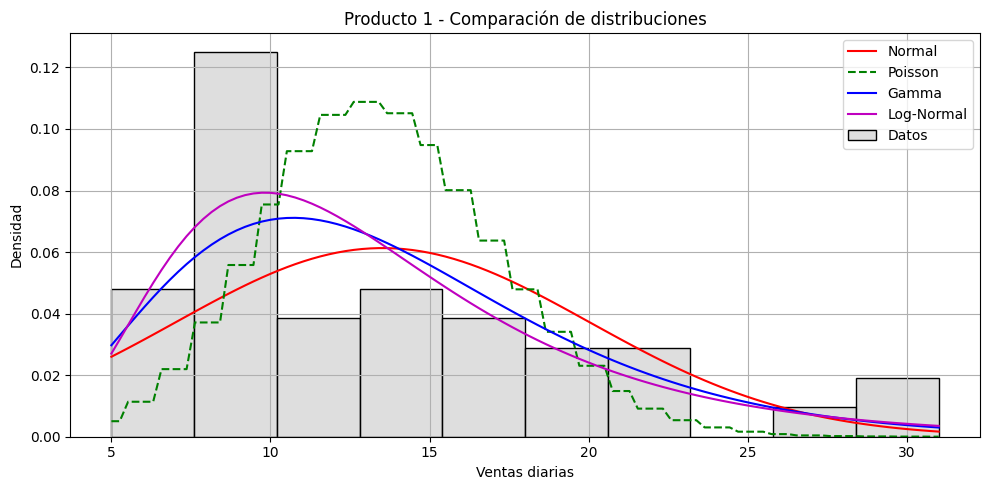

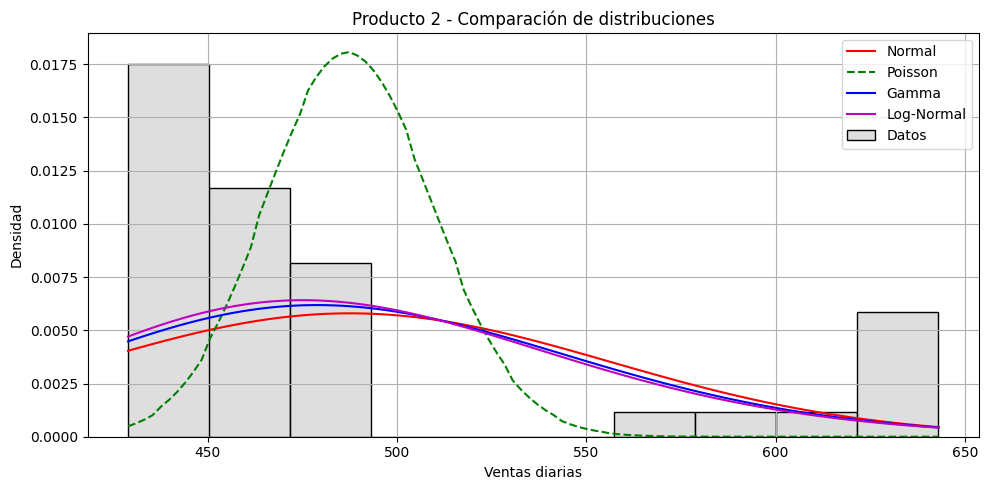

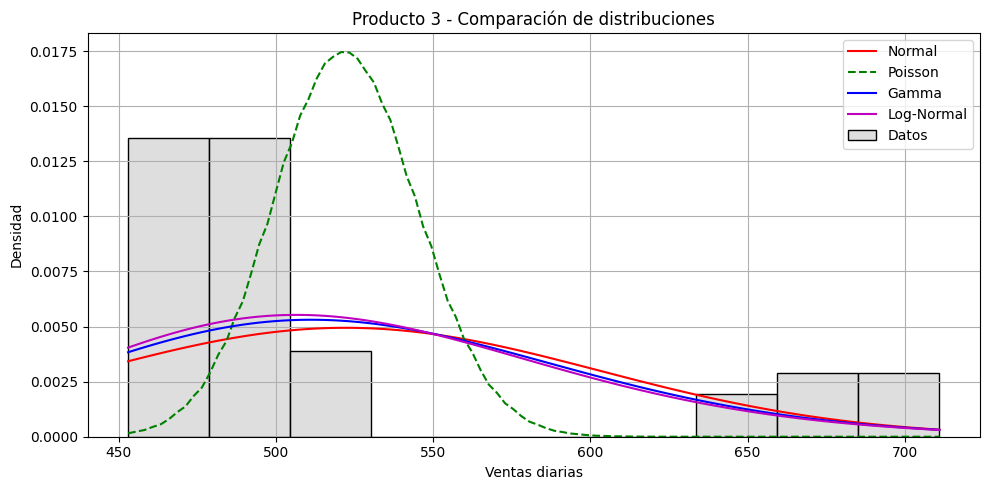

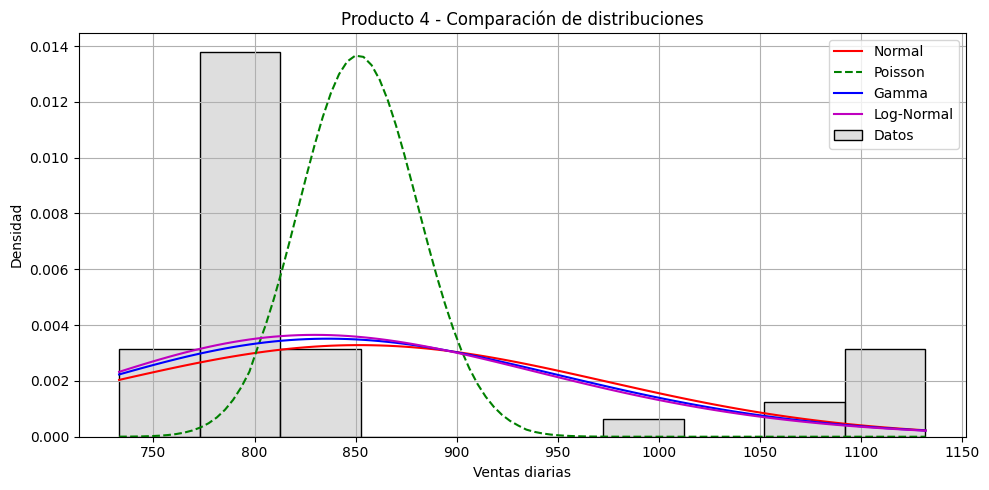

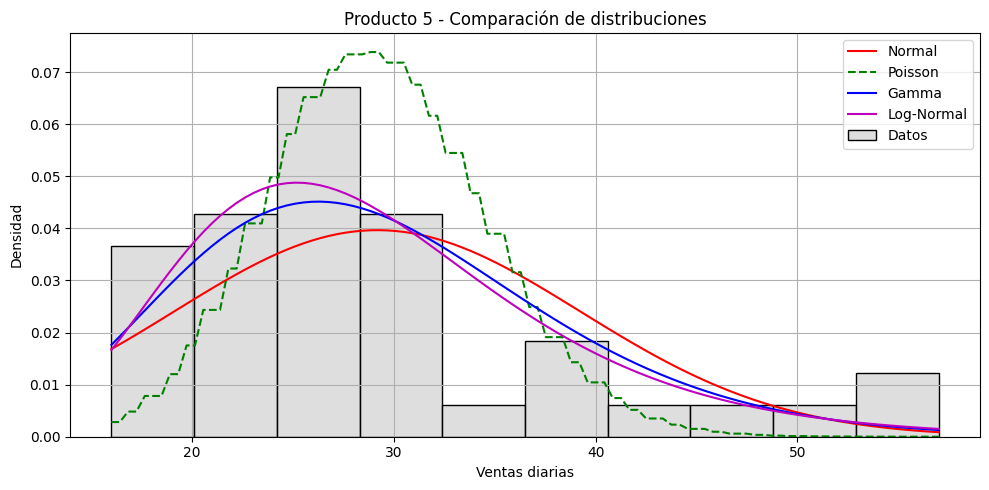

In [ ]:
# Graficar el ajuste de las distribuciones para los primeros 5 productos

productos_para_graficar = resumen_con_lognorm["id_producto"].unique()[:5]

for producto_id in productos_para_graficar:
    datos = ventas_diarias[ventas_diarias["id_producto"] == producto_id]["venta_tienda"]

    # Normal
    mu, std = norm.fit(datos)
    y_norm = norm.pdf(np.linspace(datos.min(), datos.max(), 100), mu, std)

    # Poisson
    lambda_p = datos.mean()
    y_poisson = poisson.pmf(np.round(np.linspace(datos.min(), datos.max(), 100)), lambda_p)

    # Gamma
    datos_gamma = datos[datos > 0]
    if len(datos_gamma) > 0:
        alpha_gamma, loc_gamma, scale_gamma = gamma.fit(datos_gamma, floc=0)
        y_gamma = gamma.pdf(np.linspace(datos.min(), datos.max(), 100), alpha_gamma, loc=loc_gamma, scale=scale_gamma)
    else:
        y_gamma = np.zeros(100)

    # Log-Normal
    datos_lognorm = datos[datos > 0]
    if len(datos_lognorm) > 0:
        s_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(datos_lognorm, floc=0)
        y_lognorm = lognorm.pdf(np.linspace(datos.min(), datos.max(), 100), s_lognorm, loc=loc_lognorm, scale=scale_lognorm)
    else:
        y_lognorm = np.zeros(100)

    # Plot
    x = np.linspace(datos.min(), datos.max(), 100)
    plt.figure(figsize=(10, 5))
    sns.histplot(datos, bins=10, kde=False, stat='density', color='lightgray', label='Datos')

    plt.plot(x, y_norm, 'r-', label=f'Normal')
    plt.plot(x, y_poisson, 'g--', label=f'Poisson')
    plt.plot(x, y_gamma, 'b-', label=f'Gamma')
    plt.plot(x, y_lognorm, 'm-', label=f'Log-Normal')

    plt.title(f"Producto {producto_id} - Comparación de distribuciones")
    plt.xlabel("Ventas diarias")
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Chi cuadrado

## Ventas digitales

In [ ]:
def extraer_ventas(zip_path, extract_dir="venta_zona"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    all_files = [f for f in os.listdir(extract_dir) if f.endswith(".csv")]
    all_data = []
    for f in all_files:
        df = pd.read_csv(os.path.join(extract_dir, f))
        df["archivo"] = f
        df["dia"] = int(f.split("_")[2].replace(".csv", ""))
        all_data.append(df)

    df_ventas = pd.concat(all_data, ignore_index=True)
    df_ventas.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
    return df_ventas

# === 2. Agrupar por producto y día ===
def agrupar_por_producto(df_ventas):
    return df_ventas.groupby(["id_producto", "dia"])["venta_digital"].sum().reset_index()

# === USO ===
# 1. Reemplaza 'ruta_zip' con la ruta de tu archivo .zip
ruta_zip = 'venta_zona.zip'
ventas_raw = extraer_ventas(ruta_zip)
ventas_diarias = agrupar_por_producto(ventas_raw)


In [ ]:
from scipy.stats import kstest, norm, poisson, gamma, lognorm
import numpy as np

def evaluar_distribuciones_con_lognorm_segura(ventas_df):
    productos = ventas_df["id_producto"].unique()
    resumen_resultados = []

    for producto_id in productos:
        datos = ventas_df[ventas_df["id_producto"] == producto_id]["venta_digital"]

        if datos.std() == 0:
            # Caso sin varianza: no se puede ajustar ninguna distribución
            resumen_resultados.append({
                "id_producto": producto_id,
                "pvalue_normal": np.nan,
                "pvalue_poisson": np.nan,
                "pvalue_gamma": np.nan,
                "pvalue_lognorm": np.nan,
                "mejor_ajuste": "Constante"
            })
            continue

        # Normal
        mu, std = norm.fit(datos)
        ks_normal = kstest(datos, 'norm', args=(mu, std))

        # Poisson
        lambda_p = datos.mean()
        ks_poisson = kstest(datos, 'poisson', args=(lambda_p,))

        # Gamma
        datos_gamma = datos[datos > 0]
        try:
            alpha_gamma, loc_gamma, scale_gamma = gamma.fit(datos_gamma, floc=0)
            ks_gamma = kstest(datos, 'gamma', args=(alpha_gamma, loc_gamma, scale_gamma))
        except Exception:
            ks_gamma = type('obj', (object,), {'pvalue': np.nan})()

        # Log-Normal
        datos_lognorm = datos[datos > 0]
        try:
            s_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(datos_lognorm, floc=0)
            ks_lognorm = kstest(datos, 'lognorm', args=(s_lognorm, loc_lognorm, scale_lognorm))
        except Exception:
            ks_lognorm = type('obj', (object,), {'pvalue': np.nan})()

        # Seleccionar mejor distribución solo entre p-values válidos
        p_values = {
            "Normal": ks_normal.pvalue,
            "Poisson": ks_poisson.pvalue,
            "Gamma": ks_gamma.pvalue,
            "Log-Normal": ks_lognorm.pvalue
        }
        p_values_validos = {k: v for k, v in p_values.items() if not np.isnan(v)}
        mejor = max(p_values_validos, key=p_values_validos.get) if p_values_validos else "Sin ajuste válido"

        resumen_resultados.append({
            "id_producto": producto_id,
            "pvalue_normal": ks_normal.pvalue,
            "pvalue_poisson": ks_poisson.pvalue,
            "pvalue_gamma": ks_gamma.pvalue,
            "pvalue_lognorm": ks_lognorm.pvalue,
            "mejor_ajuste": mejor
        })

    return pd.DataFrame(resumen_resultados)


# Ejecutar análisis
resumen_con_lognorm = evaluar_distribuciones_con_lognorm_segura(ventas_diarias)

# Mostrar tabla
print(resumen_con_lognorm)



      id_producto  pvalue_normal  pvalue_poisson  pvalue_gamma  \
0               1            NaN             NaN           NaN   
1               2       0.996615        0.136685      0.995499   
2               3       0.987937        0.128006      0.988811   
3               4       0.997504        0.008310      0.998130   
4               5       0.780796        0.000011      0.786738   
...           ...            ...             ...           ...   
1009         1010       0.656220        0.102782      0.668049   
1010         1011            NaN             NaN           NaN   
1011         1012       0.710930        0.221984      0.723989   
1012         1013       0.917833        0.180954      0.915885   
1013         1014       0.944752        0.014163      0.944341   

      pvalue_lognorm mejor_ajuste  
0                NaN    Constante  
1           0.994848       Normal  
2           0.989234   Log-Normal  
3           0.998393   Log-Normal  
4           0.789691   Log-

In [ ]:
archivo_salida = "resumen_zonas.xlsx"
resumen_con_lognorm.to_excel(archivo_salida, index=False)

archivo_salida

'resumen_zonas.xlsx'

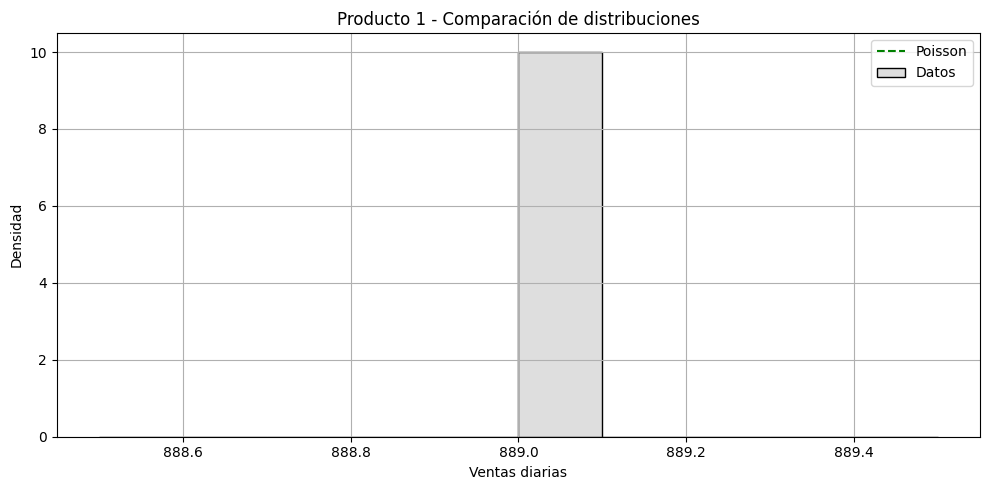

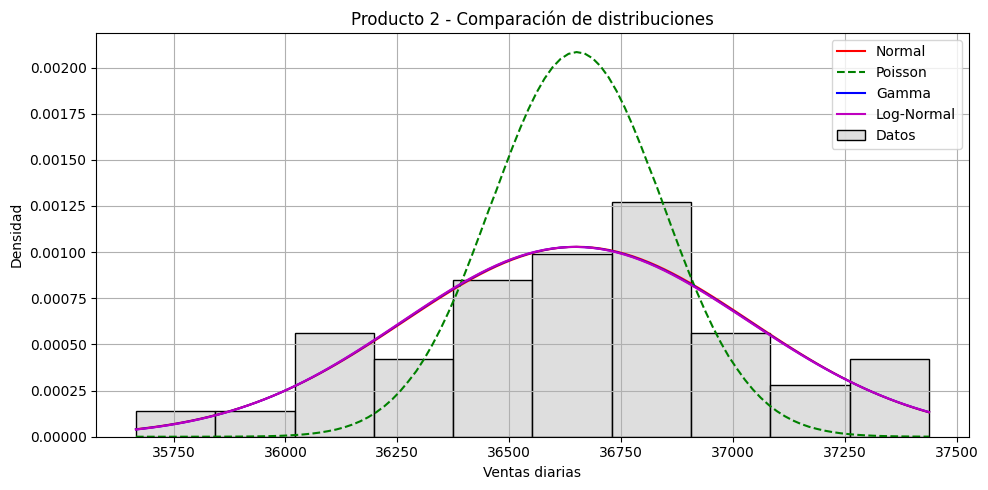

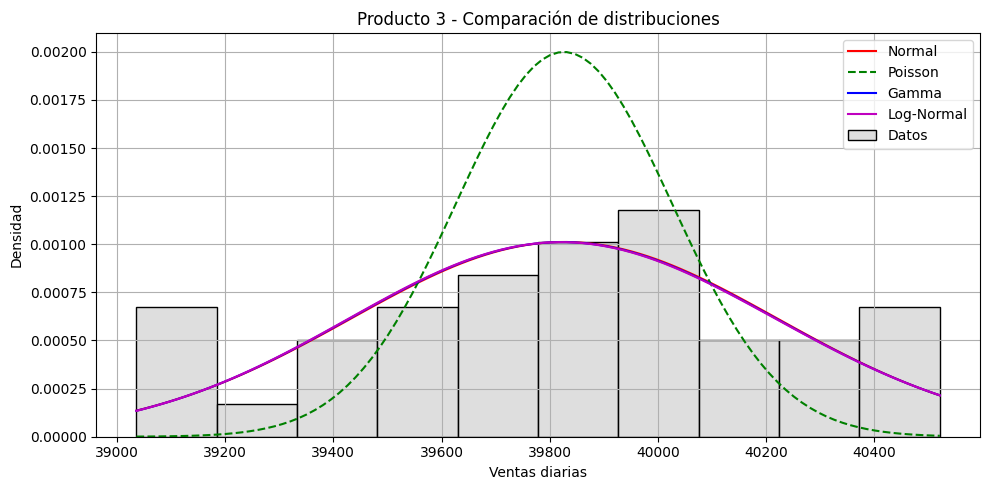

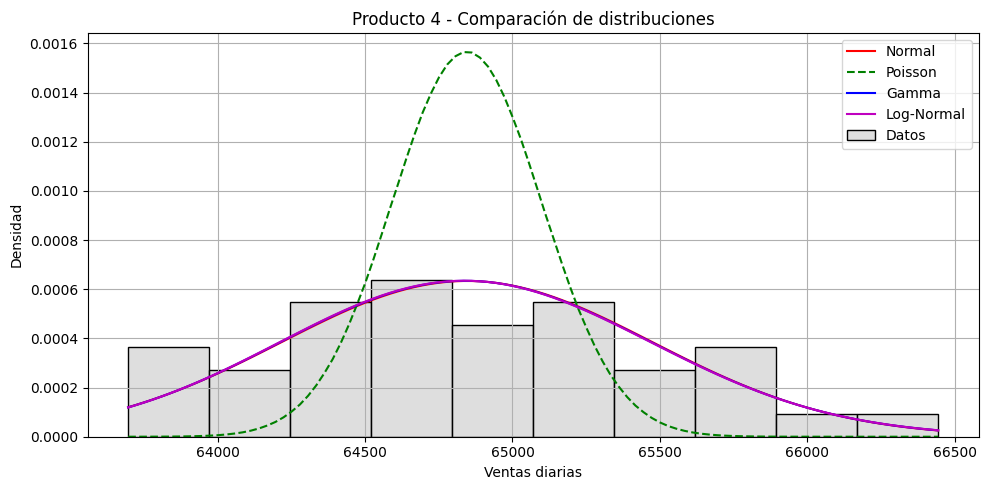

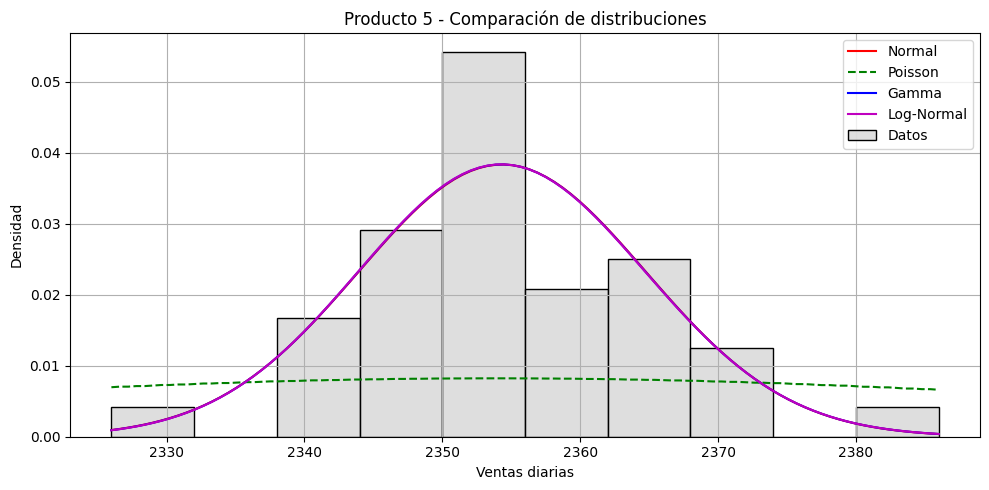

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson, gamma, lognorm

# Graficar el ajuste de las distribuciones para los primeros 5 productos
productos_para_graficar = resumen_con_lognorm["id_producto"].unique()[:5]

for producto_id in productos_para_graficar:
    datos = ventas_diarias[ventas_diarias["id_producto"] == producto_id]["venta_digital"]

    x = np.linspace(datos.min(), datos.max(), 100)

    # Inicializar con ceros (para casos sin distribución válida)
    y_norm = np.zeros_like(x)
    y_poisson = np.zeros_like(x)
    y_gamma = np.zeros_like(x)
    y_lognorm = np.zeros_like(x)

    # Normal
    if datos.std() > 0:
        mu, std = norm.fit(datos)
        y_norm = norm.pdf(x, mu, std)

    # Poisson
    if datos.mean() > 0:
        lambda_p = datos.mean()
        y_poisson = poisson.pmf(np.round(x), lambda_p)

    # Gamma
    datos_gamma = datos[datos > 0]
    if len(datos_gamma) > 0 and np.var(datos_gamma) > 0:
        alpha_gamma, loc_gamma, scale_gamma = gamma.fit(datos_gamma, floc=0)
        y_gamma = gamma.pdf(x, alpha_gamma, loc=loc_gamma, scale=scale_gamma)

    # Log-Normal
    datos_lognorm = datos[datos > 0]
    if len(datos_lognorm) > 0 and np.var(datos_lognorm) > 0:
        s_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(datos_lognorm, floc=0)
        y_lognorm = lognorm.pdf(x, s_lognorm, loc=loc_lognorm, scale=scale_lognorm)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(datos, bins=10, kde=False, stat='density', color='lightgray', label='Datos')

    if y_norm.sum() > 0:
        plt.plot(x, y_norm, 'r-', label='Normal')
    if y_poisson.sum() > 0:
        plt.plot(x, y_poisson, 'g--', label='Poisson')
    if y_gamma.sum() > 0:
        plt.plot(x, y_gamma, 'b-', label='Gamma')
    if y_lognorm.sum() > 0:
        plt.plot(x, y_lognorm, 'm-', label='Log-Normal')

    plt.title(f"Producto {producto_id} - Comparación de distribuciones")
    plt.xlabel("Ventas diarias")
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Relación de demandas

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ruta donde están los archivos
ruta1 = "venta_tienda/"
ruta2 = "venta_zona/"

# Crear listas para ir guardando los datos de cada día
lista_tienda = []
lista_zona = []

# Recorremos los 40 días
for dia in range(1, 41):
    archivo_tienda = f"{ruta1}venta_tienda_{dia}_20250115.csv"
    archivo_zona = f"{ruta2}venta_zona_{dia}_20250115.csv"

    # Cargar tienda
    df_t = pd.read_csv(archivo_tienda)
    df_t["dia"] = dia
    lista_tienda.append(df_t)

    # Cargar zona
    df_z = pd.read_csv(archivo_zona)
    df_z["dia"] = dia
    lista_zona.append(df_z)


In [ ]:
# Unir todos los días
df_tienda = pd.concat(lista_tienda, ignore_index=True)
df_zona = pd.concat(lista_zona, ignore_index=True)


In [ ]:
df_tienda = df_tienda.groupby(["id_producto", "dia"], as_index=False).agg({"venta_tienda": "sum"})
df_zona = df_zona.groupby(["id_producto", "dia"], as_index=False).agg({"venta_digital": "sum"})

In [ ]:
df_combinado = pd.merge(df_tienda, df_zona, on=["id_producto", "dia"])

Correlación global entre venta física y digital: 0.96


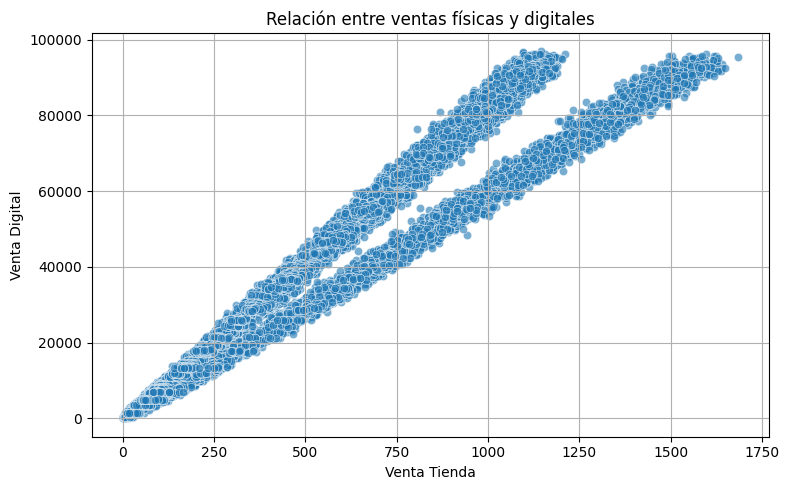

In [ ]:
# Correlación global
correlacion_global = df_combinado[["venta_tienda", "venta_digital"]].corr().iloc[0, 1]
print(f"Correlación global entre venta física y digital: {correlacion_global:.2f}")

# Gráfico de dispersión
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_combinado, x="venta_tienda", y="venta_digital", alpha=0.6)
plt.title("Relación entre ventas físicas y digitales")
plt.xlabel("Venta Tienda")
plt.ylabel("Venta Digital")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Crear lista para guardar resultados
correlaciones = []

for producto in df_combinado["id_producto"].unique():
    df_p = df_combinado[df_combinado["id_producto"] == producto]
    if len(df_p) >= 10:
        corr = df_p["venta_tienda"].corr(df_p["venta_digital"])
        correlaciones.append({"id_producto": producto, "correlacion": corr})

# Convertir a DataFrame
df_correlaciones = pd.DataFrame(correlaciones)


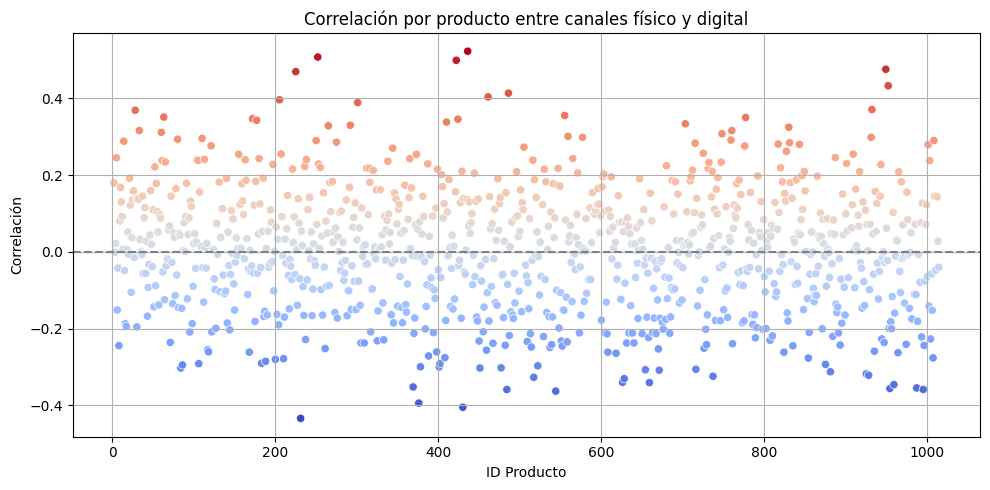

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar productos por su correlación
df_correlaciones_sorted = df_correlaciones.sort_values(by="correlacion", ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(data=df_correlaciones_sorted, x="id_producto", y="correlacion", palette="coolwarm")

plt.xticks(rotation=90)
plt.title("Correlación entre ventas físicas y digitales por producto")
plt.xlabel("ID Producto")
plt.ylabel("Correlación")
plt.grid(True)
plt.tight_layout()
plt.show()


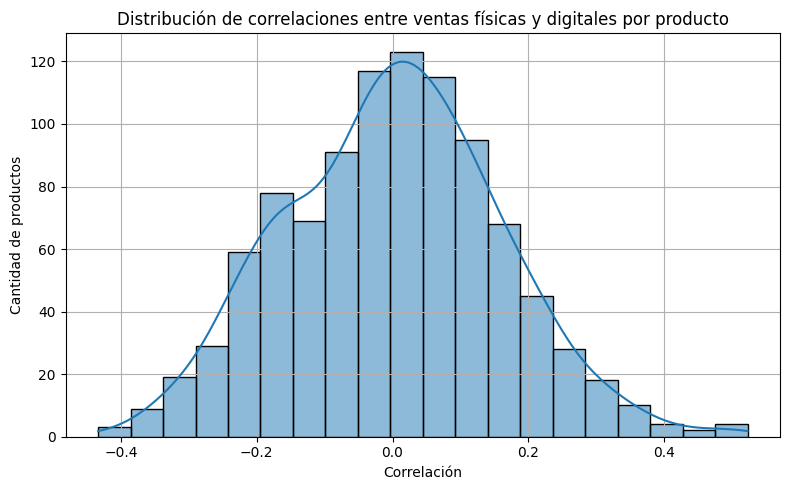

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_correlaciones["correlacion"], bins=20, kde=True)
plt.title("Distribución de correlaciones entre ventas físicas y digitales por producto")
plt.xlabel("Correlación")
plt.ylabel("Cantidad de productos")
plt.grid(True)
plt.tight_layout()
plt.show()


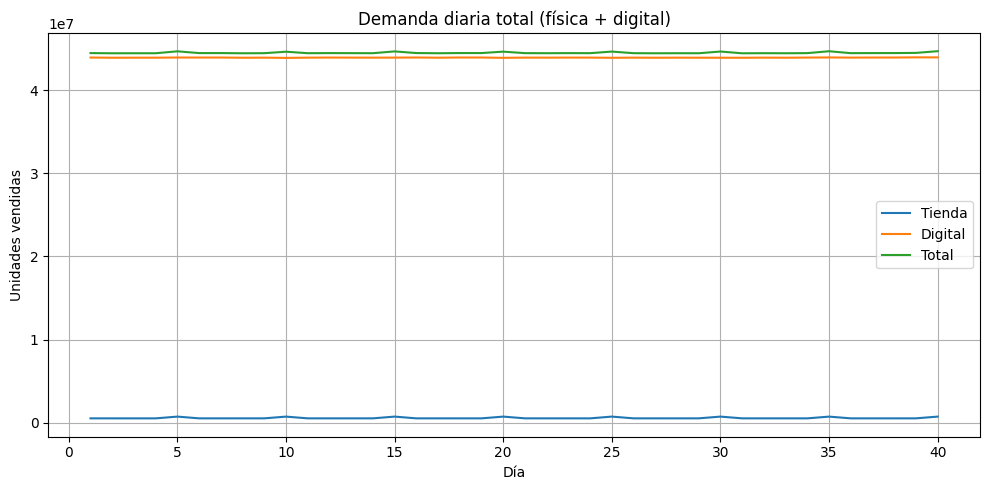

In [ ]:
demanda_diaria = df_combinado.groupby("dia")[["venta_tienda", "venta_digital"]].sum().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=demanda_diaria, x="dia", y="venta_tienda", label="Tienda")
sns.lineplot(data=demanda_diaria, x="dia", y="venta_digital", label="Digital")
sns.lineplot(data=demanda_diaria, x="dia", y=demanda_diaria["venta_tienda"] + demanda_diaria["venta_digital"], label="Total")
plt.title("Demanda diaria total (física + digital)")
plt.xlabel("Día")
plt.ylabel("Unidades vendidas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


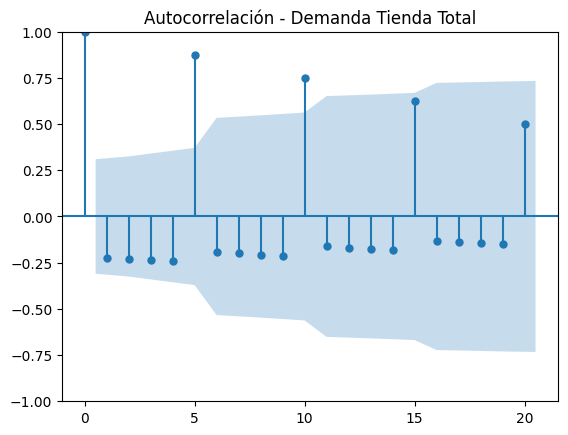

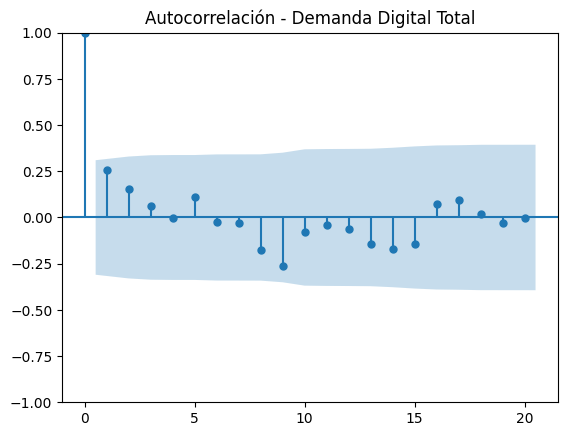

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(demanda_diaria["venta_tienda"], lags=20)
plt.title("Autocorrelación - Demanda Tienda Total")
plt.show()

plot_acf(demanda_diaria["venta_digital"], lags=20)
plt.title("Autocorrelación - Demanda Digital Total")
plt.show()


## Ratios de demanda e inventario

In [1]:
import pandas as pd
import zipfile
import glob
import numpy as np
import os
import pandas as pd
import zipfile
import re

def cargar_datos_desde_zip(path_zip, tipo='tienda'):
    datos = []
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        # Filtrar archivos del estilo correcto
        if tipo == 'tienda':
            archivos = [f for f in zip_ref.namelist() if "venta_tienda_" in f]
        elif tipo == 'zona':
            archivos = [f for f in zip_ref.namelist() if "venta_zona_" in f]
        else:
            raise ValueError("Tipo debe ser 'tienda' o 'zona'")

        # Extraer el número de día y ordenar
        archivos = sorted(archivos, key=lambda x: int(re.search(r'_(\d+)_20250115', x).group(1)))

        # Leer cada archivo con el día correspondiente
        for nombre in archivos:
            dia = int(re.search(r'_(\d+)_20250115', nombre).group(1))
            with zip_ref.open(nombre) as file:
                df = pd.read_csv(file)
                df['dia'] = dia
                datos.append(df)
    return pd.concat(datos, ignore_index=True)

ventas_tienda = cargar_datos_desde_zip('venta_tienda.zip', tipo='tienda')      # columnas esperadas: id_tienda, id_producto, cantidad, dia
ventas_zona = cargar_datos_desde_zip('venta_zona.zip', tipo='zona')          # columnas esperadas: id_zona, id_producto, cantidad, dia
zonas = pd.read_csv('zonas_20250115.csv')                                # columnas: id_zona, id_tienda (asociada), etc.
reorden = pd.read_csv('reorden_20250115.csv')                      # columnas: id_tienda, id_producto, cantidad (cada 5 días)
productos = pd.read_csv('productos_20250115.csv')                        # columnas: id_producto, volumen
flota_tienda = pd.read_csv('flota_20250115.csv')                  # columnas: id_tienda, id_camion, cantidad
camiones = pd.read_csv('vehiculos_20250115.csv')



Calculamos el inventario según ventas físicas

In [ ]:
# Hacemos el merge por id_tienda y id_producto
ventas_con_reorden = ventas_tienda.merge(
    reorden[['id_tienda', 'id_producto', 'reorden']],
    on=['id_tienda', 'id_producto'],
    how='left'
)

# Nos aseguramos de quedarnos solo con las columnas que pediste
ventas_con_reorden = ventas_con_reorden[['id_tienda', 'id_producto', 'venta_tienda', 'dia', 'reorden']]

In [ ]:
def calcular_inventario(grupo):
    grupo = grupo.sort_values('dia').copy()
    inventario_actual = 0
    inventarios = []

    for _, row in grupo.iterrows():
        dia = row['dia']
        venta = row['venta_tienda']
        reorden = row['reorden']

        if dia in [1, 6, 11, 16, 21, 26, 31, 36]:
            inventario_actual = reorden - venta
        else:
            inventario_actual = inventario_actual - venta

        inventarios.append(inventario_actual)

    grupo['inventario'] = inventarios
    return grupo

# Aplicamos la función por tienda y producto
inventario_final = ventas_con_reorden.groupby(['id_tienda', 'id_producto'], group_keys=False).apply(calcular_inventario)


<ipython-input-3-af5c63e00374>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inventario_final = ventas_con_reorden.groupby(['id_tienda', 'id_producto'], group_keys=False).apply(calcular_inventario)


In [ ]:
inventario_final = inventario_final.sort_values(by=['id_tienda', 'id_producto', 'dia']).reset_index(drop=True)

In [ ]:
inventario_final.to_csv('inventario_diario.csv', index=False)

La siguiente cantidad de veces, el inventario no es suficiente ni siquiera para abastecer la demanda física

In [ ]:
inventario_negativo = inventario_final[inventario_final['inventario'] < 0]
print(inventario_negativo)


        id_tienda  id_producto  venta_tienda  dia  reorden  inventario
51289           2          269             2   10        5          -1
207529          6          119             1   10        5          -1
207549          6          119             4   30        5          -1
416344         11          269             1   25        5          -1
416349         11          269             2   30        5          -1
428229         11          566             2   30        5          -1
428234         11          566             1   35        5          -1
450914         12          119             3   35        5          -1
456914         12          269             1   35        5          -1
468764         12          566             2    5        5          -1
468784         12          566             2   25        5          -1
497459         13          269             5   20        5          -2
497464         13          269             3   25        5          -1
549908

Ahora comparamos con las tiendas digitales

In [2]:
inventario_final = pd.read_csv('inventario_final.csv')

In [5]:
# Crear diccionario id_zona → tienda_zona
mapa_zona_tienda = zonas.set_index('id_zona')['tienda_zona'].to_dict()

# Agregar columna con .map() — mucho más liviano que merge
ventas_zona['id_tienda'] = ventas_zona['id_zona'].map(mapa_zona_tienda)

In [13]:
ventas_zona

,Unnamed: 0,id_zona,id_producto,venta_digital,dia,id_tienda
0,0,1,1,1,1,6
1,1,1,2,23,1,6
2,2,1,3,37,1,6
3,3,1,4,18,1,6
4,4,1,5,1,1,6
...,...,...,...,...,...,...
85175995,2129395,2100,1010,23,40,4
85175996,2129396,2100,1011,1,40,4
85175997,2129397,2100,1012,16,40,4
85175998,2129398,2100,1013,2,40,4


In [ ]:
# Creamos un índice compuesto (tupla) y lo usamos como diccionario
inventario_indexado = inventario_final.set_index(['id_tienda', 'id_producto', 'dia'])['inventario'].to_dict()

In [ ]:
import pandas as pd

# Preparar archivo de salida
output_path = 'zona_vs_inventario.csv'
first_write = True

# Definir tamaño del bloque
block_size = 100000
total_filas = len(ventas_zona)

for i in range(0, total_filas, block_size):
    bloque = ventas_zona.iloc[i:i+block_size].copy()

    # Lookup de inventario
    bloque['inventario'] = [
        inventario_indexado.get((tienda, producto, dia), None)
        for tienda, producto, dia in zip(bloque['id_tienda'], bloque['id_producto'], bloque['dia'])
    ]

    bloque['venta_digital'] = bloque['venta_digital'].fillna(0)
    bloque['inventario'] = bloque['inventario'].fillna(0)
    bloque['inventario_digital'] = bloque['inventario'] - bloque['venta_digital']
    # Dentro del for del procesamiento por bloques:
    bloque = bloque[bloque['inventario_digital'] < 0]


    # Guardar en CSV directamente (sin mantener en RAM)
    bloque.to_csv(output_path, mode='w' if first_write else 'a', index=False, header=first_write)
    first_write = False


In [6]:
zona_vs_inventario = pd.read_csv('zona_vs_inventario.csv')
zona_vs_inventario

,Unnamed: 0,id_zona,id_producto,venta_digital,dia,id_tienda,inventario,inventario_digital
0,850297,839,566,0,5,12,-1,-1
1,851311,840,566,0,5,12,-1,-1
2,876661,865,566,0,5,12,-1,-1
3,877675,866,566,0,5,12,-1,-1
4,878689,867,566,0,5,12,-1,-1
...,...,...,...,...,...,...,...,...
2285,1274866,1258,269,0,35,12,-1,-1
2286,1275730,1259,119,0,35,12,-1,-1
2287,1275880,1259,269,0,35,12,-1,-1
2288,1276744,1260,119,0,35,12,-1,-1


In [13]:
total_ventas_fisicas = inventario_final['venta_tienda'].sum()
ventas_fisicas_no_cubiertas = inventario_final[inventario_final['inventario'] < 0]['venta_tienda'].sum()

ratio_fisico = ventas_fisicas_no_cubiertas / total_ventas_fisicas if total_ventas_fisicas > 0 else 0

print(f"🔍 Ratio de ventas físicas no cubiertas por inventario: {ratio_fisico:.5%}")

🔍 Ratio de ventas físicas no cubiertas por inventario: 0.00019%


In [14]:
total_ventas_digitales = ventas_zona['venta_digital'].sum()
ventas_digitales_no_cubiertas = zona_vs_inventario['venta_digital'].sum()

ratio_digital = ventas_digitales_no_cubiertas / total_ventas_digitales if total_ventas_digitales > 0 else 0

print(f"🔍 Ratio de ventas digitales no cubiertas por inventario: {ratio_digital:.5%}")

🔍 Ratio de ventas digitales no cubiertas por inventario: 0.00000%


In [15]:
casos_fallidos_fisicos = len(inventario_final[inventario_final['inventario'] < 0])
total_casos_fisicos = len(inventario_final)

ratio_filas_fisico = casos_fallidos_fisicos / total_casos_fisicos if total_casos_fisicos > 0 else 0
print(f"🔍 Ratio de ventas fisicas no cubiertas por inventario: {ratio_filas_fisico:.5%}")

🔍 Ratio de ventas fisicas no cubiertas por inventario: 0.00290%


In [16]:
casos_fallidos_digitales = len(zona_vs_inventario)
total_casos_digitales = len(ventas_zona)

ratio_filas_digital = casos_fallidos_digitales / total_casos_digitales if total_casos_digitales > 0 else 0
print(f"🔍 Ratio de ventas digitales no cubiertas por inventario: {ratio_filas_digital:.5%}")

🔍 Ratio de ventas digitales no cubiertas por inventario: 0.00269%


## Ratio de volumen demandado por disponible

In [14]:
# Unir flota con capacidad por camión
flota = flota_tienda.merge(camiones, left_on='id_camion', right_on='tipo_camion', how='left')

# Calcular volumen total por tienda
flota['volumen_total'] = flota['N'] * flota['Q']

# Agrupar por tienda
capacidad_flota_por_tienda = flota.groupby('id_tienda')['volumen_total'].sum().reset_index()
capacidad_flota_por_tienda.head()

,id_tienda,volumen_total
0,1,320000000
1,2,80000000
2,3,240000000
3,4,320000000
4,5,700000000


In [2]:
# Crear diccionario de id_producto → volumen
volumen_dict = productos.set_index('id_producto')['volumen'].to_dict()

# Agregar columna volumen con .map()
ventas_zona['volumen'] = ventas_zona['id_producto'].map(volumen_dict)

In [3]:
negativos = ventas_zona[ventas_zona['volumen_total'] < 0]
print(f"Cantidad de filas con volumen negativo: {len(negativos)}")

# Si quieres revisar algunas filas
print(negativos.head())


Cantidad de filas con volumen negativo: 579204
     Unnamed: 0  id_zona  id_producto  venta_digital  dia  volumen  \
19           19        1           20              7    1       -2   
92           92        1           93             15    1      -13   
147         147        1          148             16    1      -59   
237         237        1          238             34    1       -8   
278         278        1          279              2    1       -7   

     volumen_total  
19             -14  
92            -195  
147           -944  
237           -272  
278            -14  


como hay volumenes negativos estos no pueden ser despachados, los cambiaremos por el volumen máximo


In [23]:
volumen_maximo = productos['volumen'].max()
print(f"📦 Volumen máximo: {volumen_maximo}")

📦 Volumen máximo: 236


In [26]:
ventas_zona.loc[ventas_zona['volumen'] < 0, 'volumen'] = volumen_maximo

Ahora calculamos el volumen total

In [27]:
# Calcular volumen total vendido
ventas_zona['volumen_total'] = ventas_zona['venta_digital'] * ventas_zona['volumen']

In [31]:
ventas_zona.head()

,Unnamed: 0,id_zona,id_producto,venta_digital,dia,volumen,volumen_total,id_tienda
0,0,1,1,1,1,112,112,6
1,1,1,2,23,1,147,3381,6
2,2,1,3,37,1,30,1110,6
3,3,1,4,18,1,103,1854,6
4,4,1,5,1,1,45,45,6


In [32]:
# Crear diccionario de id_zona → id_tienda
mapa_zona_tienda = zonas.set_index('id_zona')['tienda_zona'].to_dict()

# Agregar columna a ventas_zona
ventas_zona['id_tienda'] = ventas_zona['id_zona'].map(mapa_zona_tienda)

In [33]:
volumen_digital_por_tienda_dia = ventas_zona.groupby(['id_tienda', 'dia'])['volumen_total'].sum().reset_index()

In [34]:
volumen_digital_por_tienda_dia.head()

,id_tienda,dia,volumen_total
0,1,1,253966111
1,1,2,254923453
2,1,3,254448582
3,1,4,254027894
4,1,5,254247656


In [35]:
comparacion = volumen_digital_por_tienda_dia.merge(
    capacidad_flota_por_tienda,
    on='id_tienda',
    how='left'
)
comparacion.head()

,id_tienda,dia,volumen_total_x,volumen_total_y
0,1,1,253966111,320000000
1,1,2,254923453,320000000
2,1,3,254448582,320000000
3,1,4,254027894,320000000
4,1,5,254247656,320000000


In [36]:
# Ratio: cuánta capacidad se usó
comparacion['ratio_uso_flota'] = comparacion['volumen_total_x'] / comparacion['volumen_total_y']
comparacion = comparacion.rename(columns={'volumen_total_x': 'volumen_vendido_digital', 'volumen_total_y': 'capacidad_flota'})
comparacion.head()

,id_tienda,dia,volumen_vendido_digital,capacidad_flota,ratio_uso_flota
0,1,1,253966111,320000000,0.793644
1,1,2,254923453,320000000,0.796636
2,1,3,254448582,320000000,0.795152
3,1,4,254027894,320000000,0.793837
4,1,5,254247656,320000000,0.794524


In [37]:
# Crear columna booleana: True si la flota alcanzó, False si no
comparacion['flota_suficiente'] = comparacion['capacidad_flota'] >= comparacion['volumen_vendido_digital']
flota_insuficiente = comparacion[comparacion['flota_suficiente'] == False]
print(flota_insuficiente)

Empty DataFrame
Columns: [id_tienda, dia, volumen_vendido_digital, capacidad_flota, ratio_uso_flota, flota_suficiente]
Index: []


In [38]:
comparacion.to_csv('q_oferta_demanda.csv', index=False)

In [39]:
import pandas as pd

q_oferta_demanda = pd.read_csv('q_oferta_demanda.csv')
q_oferta_demanda.head()

,id_tienda,dia,volumen_vendido_digital,capacidad_flota,ratio_uso_flota,flota_suficiente
0,1,1,253966111,320000000,0.793644,True
1,1,2,254923453,320000000,0.796636,True
2,1,3,254448582,320000000,0.795152,True
3,1,4,254027894,320000000,0.793837,True
4,1,5,254247656,320000000,0.794524,True


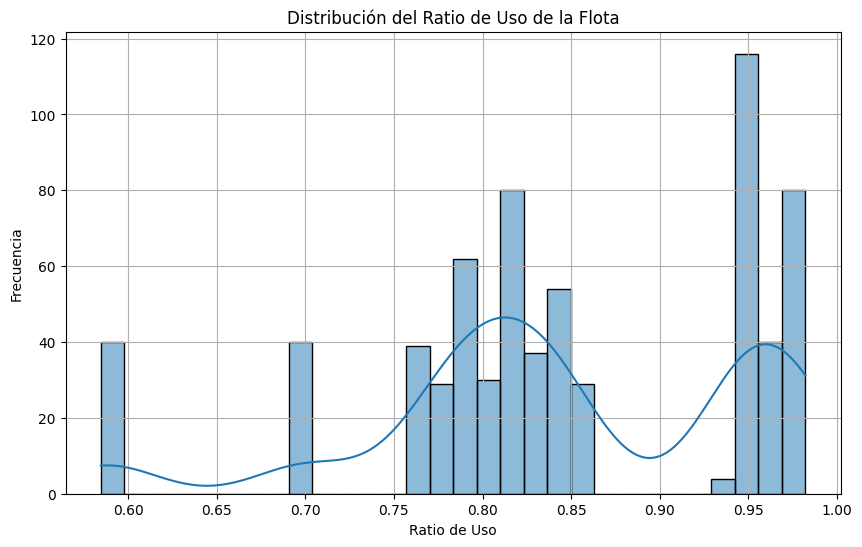

In [40]:
# prompt: gráfico de ratio_uso_flota

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'comparacion' DataFrame is already created as in your provided code
# ... (your existing code) ...

plt.figure(figsize=(10, 6))
sns.histplot(q_oferta_demanda['ratio_uso_flota'], bins=30, kde=True)
plt.title('Distribución del Ratio de Uso de la Flota')
plt.xlabel('Ratio de Uso')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()
